# Practical Deep Learning for Coders V4 Course - My learnings from Lesson 1

From Lesson 1 of the V4 course currently being run we're using copies of the notebook code embedded in their new book. So below are my experiments from what I learnt here, starting from scratch but drawing heavily from their textbook code. I run this locally on Windows 10 (I can see Jeremy's eye rolling if he reads this since he recommended against this for beginners) but in my defense I did do the course last year and had my laptop configured with V1 of Fastai running so thought I'd see where the stress points were, but to keep productive I also run on Google Collab which is honestly much easier. As a caveat, I'm writing this article while running Jupyter Notebook on the Windows 10 environment so if some code looks slightly modified I'll try to mention explicitly this is a Win10 specific change. Now, on to the experimentation.

First if you're running this locally make sure you have the "Trusted" button enable for this notebook. 

Now we're going to make sure fastai is installed into my local environment

In [4]:
pip install fastai2


Note: you may need to restart the kernel to use updated packages.


Now in the notebook and the V4 course repo, Jeremy hides alot of the guts of getting things up and running with

In [2]:
#hide
# from utils import *

But since I like to dig into things I'm going to try to parse the `utils.py` file and pull out just the pieces we need to get Lesson 1 stuff up and running

In [3]:
from fastai2.vision.all import *

I also want to test my environment to make sure I have a Nvidia GPU and probe for some details on it

In [5]:
import torch
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

In [7]:
import torch.cuda
if torch.cuda.is_available():
    print('PyTorch found cuda')
else:
    print('PyTorch could not find cuda')

PyTorch found cuda


There's a block of code in the notebook that executes a learner on images data of both cats and dogs and their breeds. I'm segmenting that code below and putting notes on each

First he gets the data from the built in `URLS` object for `PETS` data which is a simple Amazon S3 storage bucket location containing what looks like either the originally or slightly modified copy of [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [10]:
print(URLs.PETS)

https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz


So we use a method `untar_data` to decompress this into our local `images` folder. In the next block if you uncomment the code and press `Shift-Tab` 3 (or 4 times for a pop out window) you can see the documentation on the function and the parameters it takes

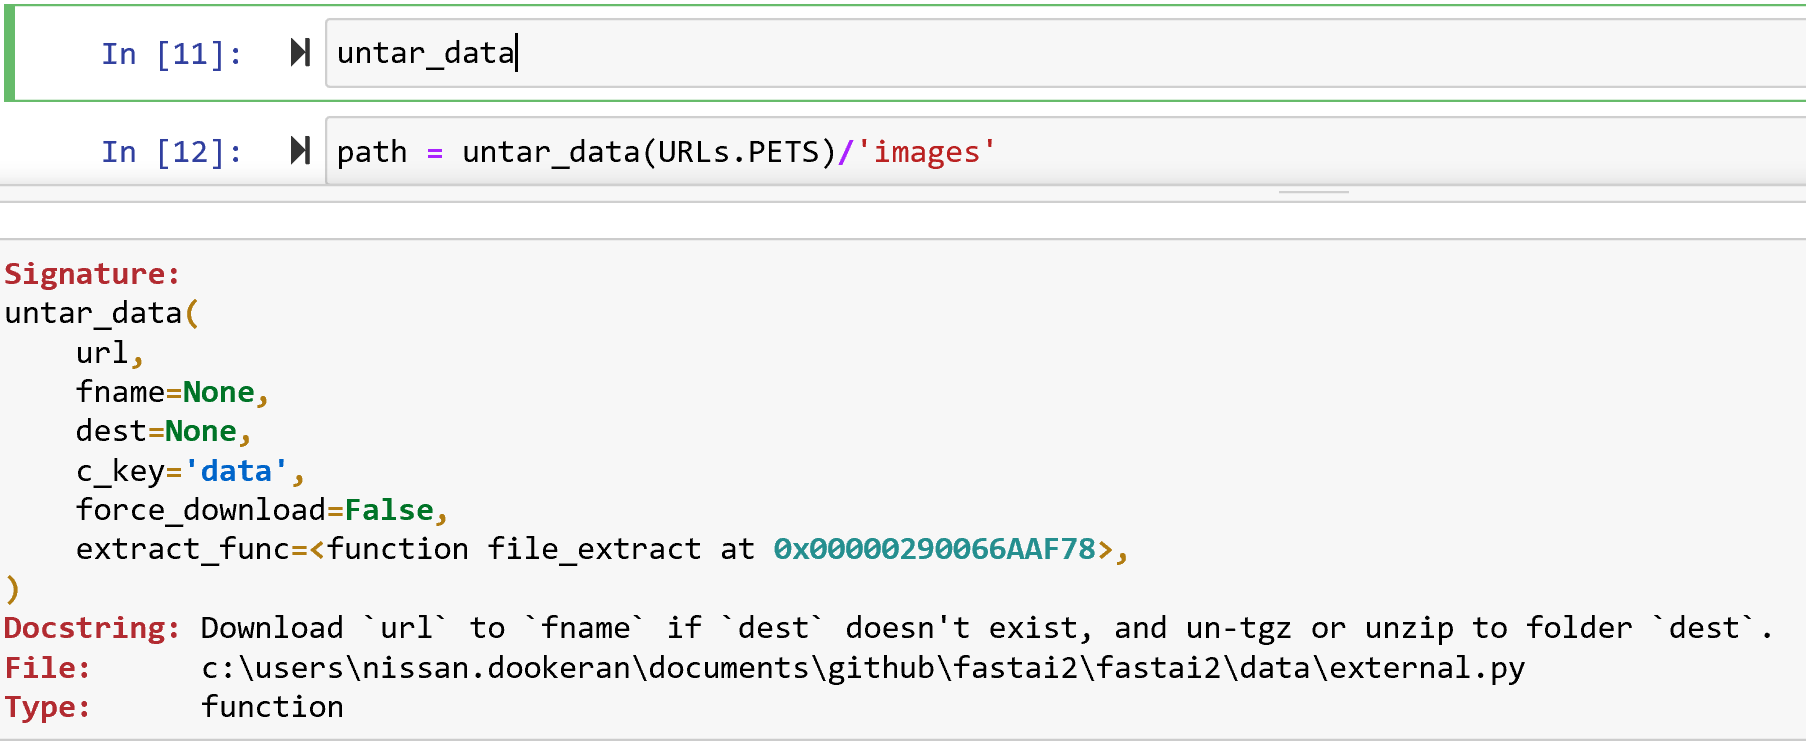

In [14]:
untar_data

<function fastai2.data.external.untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=<function file_extract at 0x00000290066AAF78>)>

In [12]:
path = untar_data(URLs.PETS)/'images'

So this had me scratching for awhile when I read the notebook but then in the video Jeremy explained the need for this function. Apparently because it is a mixture of both cats and dogs and their breeds, the way to identify data as being for a cat is to Capitalize The First Letter For Any Cat Breed. So the function below would be reused when classifying data as a Cat before going deeper into identifying its breed.

In [13]:
def is_cat(x): return x[0].isupper()

The `ImageDataLoaders` function is handy as it has a variety of extensions to make loading from various image sources much easier. FastAI has this concept of a `DataLoader` that holds the data we're going to train and validate our model on. Because I'm running this on Windows 10, I had to add an additional parameter of `num_workers=0` to the call to make sure it doesn't crash. For Linux users, you can safely remove this call.

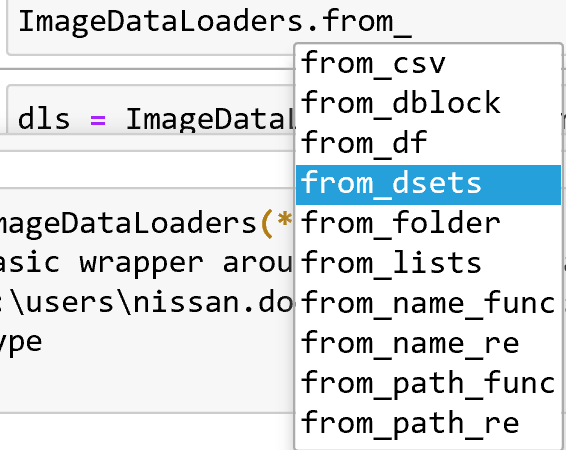

In [ ]:
ImageDataLoaders.from_ #press Tab once to see all possible calls

In [15]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224), num_workers=0)

So now we're going to call the learner that will train the model to recognise the various cats and dogs breeds in our model using the [ResNet34](https://arxiv.org/abs/1512.03385) pre-trained model. A pre-trained model is a very cool concept. Normally to start training a series of weights are chosen at random and over time are changed to better match a specific set of data. These weights are re-usable since basically it lets us jumpstart training a new, related dataset as these pre-trained series of weights are a better starting point than "random" for the new more niche subset of related data. Here we also specifiy the metric we're using as a measure of accuracy, fastai defines one for us that's useful, appropriately called `error_rate`

In [ ]:
error_rate # Press Shift+Tab 3 times to see the documentation on this

In [16]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Fast.ai V2 also introduced this nice method called `fine_tune` which basially runs a cycle of training again using a learning rate it has pre-determined as best for training to "fine tune" the model to produce better accuracy. I won't propose to understand it fully yet, but from what I know it freezes a fixed number of the hidden layers of the pre-trained model, and unfreezes the last few layers so their weights can be changed to better match the niche dataset. The logic is sound as the first set of layers would already be really good at recognising general features common in all images of the superset, but the last few layers can now be fine tuned to match the explicit features in the specific classifications of the niche dataset we are presenting for training in this model. As I learn I may write more about how I understand this function to work and append this post to match what I learn. Note, this step might take some time to execute depending on the speed and memory of the GPU you have running. Google Collab would take about 5 minutes. My local laptop running Windows 10 takes a little longer.

In [17]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.171001,0.023034,0.008119,04:04


epoch,train_loss,valid_loss,error_rate,time
0,0.053063,0.024095,0.006766,03:59


So now we have a trained model that looks like it has a pretty low error rate and we want to test it with something it hasn't seen before. This library in the next code block was added early in V3 of the course and is more prominent in V4 and lets you put GUI elements you're used to in a normal application (like a file uploader) into the notebook. I did a quick web search for a cat, downloaded that file and used it here to test.

In [19]:
from ipywidgets import widgets
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

The next block of code simply looks at the image we loaded, passes it to our model for an evaluation of whether or not it thinks it's a cat. I'd recommend having both a dog and a cat image available to test on your own

In [20]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 1.000000


And there you go. That simple. You're now a deep learning practitioner like me so celebrate the accomplishment.
youtube:https://www.youtube.com/watch?v=535Zy_rf4NU